# 🚜 Predicting the Sale Price of Bulldozers using Machine Learning

In this notebook, we're going to go through an example machine learning project with the goal of predicting the sale price of bulldozers.

The techniques used in here have been inspired and adapted from the [fast.ai machine learning course](https://course18.fast.ai/ml).

## 1. Problem Definition

> How well can we predict the future sale price of a bulldozer, given its characteristics and previous examples of how much similar bulldozers have been sold for?

## 2. Data

The data is downloaded from the [Kaggle Bluebook for Bulldozers competition](https://www.kaggle.com/c/bluebook-for-bulldozers/overview).

There are 3 main datasets:

- `Train.csv` is the training set, which contains data through the end of 2011.
- `Valid.csv` is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
- `Test.csv` is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

## 3. Evaluation
The evaluation metric for this competition is the RMSLE (root mean squared log error) between the actual and predicted auction prices.

For more on the evaluation of this project check the [Kaggle Bluebook for Bulldozers competition overview](https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation).

> **Note:** The goal for most regression evaluation metrics is to minimize the error. For example, our goal for this project will be to build a machine learning model which minimises RMSLE.

To see how well our model is doing, we'll calculate the RMSLE and then compare our results to others on the [Kaggle leaderboard](https://www.kaggle.com/c/bluebook-for-bulldozers/leaderboard).

## 4. Features

Kaggle provides a [data dictionary](./data/Data%20Dictionary.xlsx) detailing all of the features of the dataset. You can also view this data dictionary on [Google Sheets](https://docs.google.com/spreadsheets/d/18ly-bLR8sbDJLITkWG7ozKm8l3RyieQ2Fpgix-beSYI/edit?usp=sharing).

### 4.1. Importing the data and preparing it for modelling

First, we'll import the dataset and start exploring. Since we know the evaluation metric we're trying to minimise, our first goal will be building a baseline model and seeing how it stacks up against the competition:

In [76]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_log_error, mean_absolute_error

Now we've got our tools for data analysis ready, we can import the data and start to explore it.

For this project, we've [downloaded the data from Kaggle](https://www.kaggle.com/c/bluebook-for-bulldozers/data) and stored it under the file path `"./data/"`.

The provided data also helpfully combines the training and validation sets in a single file called `TrainAndValid.csv`, so we shall be using that here:

In [77]:
df = pd.read_csv("./data/TrainAndValid.csv", low_memory=False)

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

In [79]:
df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

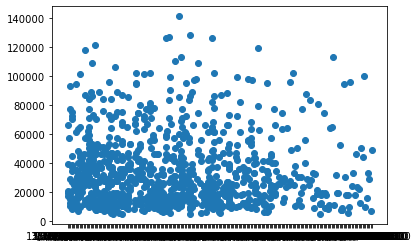

In [5]:
fig, ax = plt.subplots()
ax.scatter(df["saledate"][:1000], df["SalePrice"][:1000]);

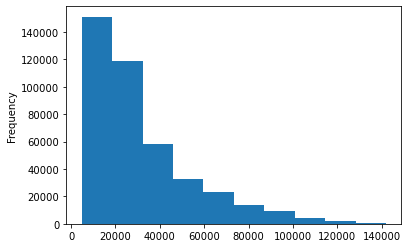

In [6]:
df["SalePrice"].plot.hist();

### 4.2. Parsing dates

When working with time series data, it's a good idea to make sure any date data is the format of a [datetime object](https://docs.python.org/3/library/datetime.html) (a Python data type which encodes specific information about dates).

In [7]:
df["saledate"].dtype

dtype('O')

In [8]:
df["saledate"].head()

0    11/16/2006 0:00
1     3/26/2004 0:00
2     2/26/2004 0:00
3     5/19/2011 0:00
4     7/23/2009 0:00
Name: saledate, dtype: object

When we work with time series data, we want to enrich the time & date component as much as possible.

We can do that by telling pandas which of our columns has dates in it using the `parse_dates` parameter:

In [9]:
df = pd.read_csv("./data/TrainAndValid.csv",
                 low_memory=False,
                 parse_dates=["saledate"])

In [10]:
df["saledate"].dtype

dtype('<M8[ns]')

In [11]:
df["saledate"].head()

0   2006-11-16
1   2004-03-26
2   2004-02-26
3   2011-05-19
4   2009-07-23
Name: saledate, dtype: datetime64[ns]

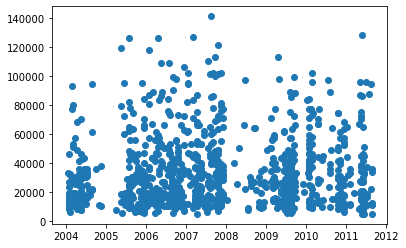

In [12]:
fig, ax = plt.subplots()
ax.scatter(df["saledate"][:1000], df["SalePrice"][:1000]);

In [13]:
df.head().T

0  \
SalesID                                                    1139246   
SalePrice                                                  66000.0   
MachineID                                                   999089   
ModelID                                                       3157   
datasource                                                     121   
auctioneerID                                                   3.0   
YearMade                                                      2004   
MachineHoursCurrentMeter                                      68.0   
UsageBand                                                      Low   
saledate                                       2006-11-16 00:00:00   
fiModelDesc                                                   521D   
fiBaseModel                                                    521   
fiSecondaryDesc                                                  D   
fiModelSeries                                                  NaN   
fiModelDescriptor                                              NaN   
ProductSize                                                    NaN   
fiProductClassDesc        Wheel Loader - 110.0 to 120.0 Horsepower   
state                                                      Alabama   
ProductGroup                                                    WL   
ProductGroupDesc                                      Wheel Loader   
Drive_System                                                   NaN   
Enclosure                                               EROPS w AC   
Forks                                          None or Unspecified   
Pad_Type                                                       NaN   
Ride_Control                                   None or Unspecified   
Stick                                                          NaN   
Transmission                                                   NaN   
Turbocharged                                                   NaN   
Blade_Extension                                                NaN   
Blade_Width                                                    NaN   
Enclosure_Type                                                 NaN   
Engine_Horsepower                                              NaN   
Hydraulics                                                 2 Valve   
Pushblock                                                      NaN   
Ripper                                                         NaN   
Scarifier                                                      NaN   
Tip_Control                                                    NaN   
Tire_Size                                      None or Unspecified   
Coupler                                        None or Unspecified   
Coupler_System                                                 NaN   
Grouser_Tracks                                                 NaN   
Hydraulics_Flow                                                NaN   
Track_Type                                                     NaN   
Undercarriage_Pad_Width                                        NaN   
Stick_Length                                                   NaN   
Thumb                                                          NaN   
Pattern_Changer                                                NaN   
Grouser_Type                                                   NaN   
Backhoe_Mounting                                               NaN   
Blade_Type                                                     NaN   
Travel_Controls                                                NaN   
Differential_Type                                         Standard   
Steering_Controls                                     Conventional   

                                                                 1  \
SalesID                                                    1139248   
SalePrice                                                  57000.0   
MachineID                                                   117657   
Mode

#### 4.2.1. Sort DataFrame by saledate

As we're working on a time series problem and trying to predict future examples given past examples, it makes sense to sort our data by date.

In [14]:
df.sort_values(by=["saledate"], inplace=True, ascending=True)
df["saledate"].head(20)

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
54653    1989-01-31
81383    1989-01-31
204924   1989-01-31
135376   1989-01-31
113390   1989-01-31
113394   1989-01-31
116419   1989-01-31
32138    1989-01-31
127610   1989-01-31
76171    1989-01-31
127000   1989-01-31
128130   1989-01-31
127626   1989-01-31
55455    1989-01-31
55454    1989-01-31
Name: saledate, dtype: datetime64[ns]

### 4.3. Make a copy of the original DataFrame

Since we're going to be manipulating the data, we'll make a copy of the original DataFrame and perform our changes there.

This will keep the original DataFrame intact if we need it again.

In [15]:
df_tmp = df.copy()

### 4.4. Add datetime parameters for `saledate` column

We want to enrich our dataset with as much information as possible.

Because we imported the data using `read_csv()` and we asked pandas to parse the dates using `parse_dates=["saledate"]`, we can now access the [different datetime attributes](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DatetimeIndex.html) of the `saledate` column.

In [16]:
df_tmp["saleYear"] = df_tmp["saledate"].dt.year
df_tmp["saleMonth"] = df_tmp["saledate"].dt.month
df_tmp["saleDay"] = df_tmp["saledate"].dt.day
df_tmp["saleDayofweek"] = df_tmp["saledate"].dt.dayofweek
df_tmp["saleDayofyear"] = df_tmp["saledate"].dt.dayofyear

# Drop original saledate
df_tmp.drop("saledate", axis=1, inplace=True)

In [17]:
df_tmp.head().T

205615  \
SalesID                                                             1646770   
SalePrice                                                            9500.0   
MachineID                                                           1126363   
ModelID                                                                8434   
datasource                                                              132   
auctioneerID                                                           18.0   
YearMade                                                               1974   
MachineHoursCurrentMeter                                                NaN   
UsageBand                                                               NaN   
fiModelDesc                                                            TD20   
fiBaseModel                                                            TD20   
fiSecondaryDesc                                                         NaN   
fiModelSeries                                                           NaN   
fiModelDescriptor                                                       NaN   
ProductSize                                                          Medium   
fiProductClassDesc        Track Type Tractor, Dozer - 105.0 to 130.0 Hor...   
state                                                                 Texas   
ProductGroup                                                            TTT   
ProductGroupDesc                                        Track Type Tractors   
Drive_System                                                            NaN   
Enclosure                                                             OROPS   
Forks                                                                   NaN   
Pad_Type                                                                NaN   
Ride_Control                                                            NaN   
Stick                                                                   NaN   
Transmission                                                   Direct Drive   
Turbocharged                                                            NaN   
Blade_Extension                                                         NaN   
Blade_Width                                                             NaN   
Enclosure_Type                                                          NaN   
Engine_Horsepower                                                       NaN   
Hydraulics                                                          2 Valve   
Pushblock                                                               NaN   
Ripper                                                  None or Unspecified   
Scarifier                                                               NaN   
Tip_Control                                                             NaN   
Tire_Size                                                               NaN   
Coupler                                                                 NaN   
Coupler_System                                                          NaN   
Grouser_Tracks                                                          NaN   
Hydraulics_Flow                                                         NaN   
Track_Type                                                              NaN   
Undercarriage_Pad_Width                                                 NaN   
Stick_Length                                                            NaN   
Thumb                                                                   NaN   
Pattern_Changer                                                         NaN   
Grouser_Type                                                            NaN   
Backhoe_Mounting                                        None or Unspecified   
Blade_Type                                                         Straight   
Travel_Controls                                         None or Unspecified   
Differential_Type                       

### 4.5. Checking the values of different columns

In [18]:
df_tmp["state"].value_counts()

Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Montana            1336
Iowa               1336
Oklahoma           1326
Nebraska            866
West Virginia   

## 5. Modelling

We've explored our dataset a little as well as enriched it with some datetime attributes, now let's try to model.

We could spend more time doing exploratory data analysis (EDA), but since we know the evaluation metric we're heading towards, we can create a baseline metric via a machine learning model and help us do more EDA as we try and tweak our model.

However, there's some preliminary steps we first need to take before we can fit a model into our dataset.

Going back to the basic information about our dataset, we can see that we have some missing categories:

In [19]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   fiModelDesc               412698 non-null  object 
 10  fiBaseModel               412698 non-null  object 
 11  fiSecondaryDesc           271971 non-null  object 
 12  fiModelSeries             58667 non-null   object 
 13  fiModelDescriptor         74816 non-nul

In [20]:
df_tmp.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension             386715
Blade_Width         

### 5.1. Convert strings into categories

We also need to convert string values into a more manageable categorical datatype.

Let's see which columns in our data have strings:

In [21]:
df_tmp.head().T

205615  \
SalesID                                                             1646770   
SalePrice                                                            9500.0   
MachineID                                                           1126363   
ModelID                                                                8434   
datasource                                                              132   
auctioneerID                                                           18.0   
YearMade                                                               1974   
MachineHoursCurrentMeter                                                NaN   
UsageBand                                                               NaN   
fiModelDesc                                                            TD20   
fiBaseModel                                                            TD20   
fiSecondaryDesc                                                         NaN   
fiModelSeries                                                           NaN   
fiModelDescriptor                                                       NaN   
ProductSize                                                          Medium   
fiProductClassDesc        Track Type Tractor, Dozer - 105.0 to 130.0 Hor...   
state                                                                 Texas   
ProductGroup                                                            TTT   
ProductGroupDesc                                        Track Type Tractors   
Drive_System                                                            NaN   
Enclosure                                                             OROPS   
Forks                                                                   NaN   
Pad_Type                                                                NaN   
Ride_Control                                                            NaN   
Stick                                                                   NaN   
Transmission                                                   Direct Drive   
Turbocharged                                                            NaN   
Blade_Extension                                                         NaN   
Blade_Width                                                             NaN   
Enclosure_Type                                                          NaN   
Engine_Horsepower                                                       NaN   
Hydraulics                                                          2 Valve   
Pushblock                                                               NaN   
Ripper                                                  None or Unspecified   
Scarifier                                                               NaN   
Tip_Control                                                             NaN   
Tire_Size                                                               NaN   
Coupler                                                                 NaN   
Coupler_System                                                          NaN   
Grouser_Tracks                                                          NaN   
Hydraulics_Flow                                                         NaN   
Track_Type                                                              NaN   
Undercarriage_Pad_Width                                                 NaN   
Stick_Length                                                            NaN   
Thumb                                                                   NaN   
Pattern_Changer                                                         NaN   
Grouser_Type                                                            NaN   
Backhoe_Mounting                                        None or Unspecified   
Blade_Type                                                         Straight   
Travel_Controls                                         None or Unspecified   
Differential_Type                       

In [22]:
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


One way to help turn all of our data into numbers is to convert the columns with the string datatype into a category datatype.

To do this we can use the [pandas types API](https://pandas.pydata.org/pandas-docs/stable/reference/general_utility_functions.html#data-types-related-functionality) which allows us to interact and manipulate the types of data:

In [23]:
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        df_tmp[label] = content.astype("category").cat.as_ordered()

df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor       

We can then check out the converted category values like so:

In [24]:
df_tmp["state"].cat.categories

Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Unspecified', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'Washington DC', 'West Virginia', 'Wisconsin',
       'Wyoming'],
      dtype='object')

In [25]:
df_tmp["state"].cat.codes.head()

205615    43
274835     8
141296     8
212552     8
62755      8
dtype: int8

All of our data is categorical and thus we now have a way to access all of our data and turn the categories into numbers. However, there's still missing values we need to sort out.

In [26]:
df_tmp.isnull().sum()/len(df_tmp)

SalesID                     0.000000
SalePrice                   0.000000
MachineID                   0.000000
ModelID                     0.000000
datasource                  0.000000
auctioneerID                0.048791
YearMade                    0.000000
MachineHoursCurrentMeter    0.642586
UsageBand                   0.821492
fiModelDesc                 0.000000
fiBaseModel                 0.000000
fiSecondaryDesc             0.340993
fiModelSeries               0.857845
fiModelDescriptor           0.818715
ProductSize                 0.524851
fiProductClassDesc          0.000000
state                       0.000000
ProductGroup                0.000000
ProductGroupDesc            0.000000
Drive_System                0.740520
Enclosure                   0.000809
Forks                       0.520921
Pad_Type                    0.803498
Ride_Control                0.629928
Stick                       0.803498
Transmission                0.544444
Turbocharged                0.803498
B

### 5.2. Save processed data

The data is still good to be worked with in the format it's in, so let's save it to file and reimport it so we can continue on.

In [27]:
df_tmp.to_csv("./data/train_tmp.csv", index=False)

Now that we've saved a temporary file for our preprocessed data, we can just (re-)import it at any time like so:

In [28]:
df_tmp = pd.read_csv("./data/train_tmp.csv", low_memory=False)
df_tmp.head().T

0  \
SalesID                                                             1646770   
SalePrice                                                            9500.0   
MachineID                                                           1126363   
ModelID                                                                8434   
datasource                                                              132   
auctioneerID                                                           18.0   
YearMade                                                               1974   
MachineHoursCurrentMeter                                                NaN   
UsageBand                                                               NaN   
fiModelDesc                                                            TD20   
fiBaseModel                                                            TD20   
fiSecondaryDesc                                                         NaN   
fiModelSeries                                                           NaN   
fiModelDescriptor                                                       NaN   
ProductSize                                                          Medium   
fiProductClassDesc        Track Type Tractor, Dozer - 105.0 to 130.0 Hor...   
state                                                                 Texas   
ProductGroup                                                            TTT   
ProductGroupDesc                                        Track Type Tractors   
Drive_System                                                            NaN   
Enclosure                                                             OROPS   
Forks                                                                   NaN   
Pad_Type                                                                NaN   
Ride_Control                                                            NaN   
Stick                                                                   NaN   
Transmission                                                   Direct Drive   
Turbocharged                                                            NaN   
Blade_Extension                                                         NaN   
Blade_Width                                                             NaN   
Enclosure_Type                                                          NaN   
Engine_Horsepower                                                       NaN   
Hydraulics                                                          2 Valve   
Pushblock                                                               NaN   
Ripper                                                  None or Unspecified   
Scarifier                                                               NaN   
Tip_Control                                                             NaN   
Tire_Size                                                               NaN   
Coupler                                                                 NaN   
Coupler_System                                                          NaN   
Grouser_Tracks                                                          NaN   
Hydraulics_Flow                                                         NaN   
Track_Type                                                              NaN   
Undercarriage_Pad_Width                                                 NaN   
Stick_Length                                                            NaN   
Thumb                                                                   NaN   
Pattern_Changer                                                         NaN   
Grouser_Type                                                            NaN   
Backhoe_Mounting                                        None or Unspecified   
Blade_Type                                                         Straight   
Travel_Controls                                         None or Unspecified   
Differential_Type                            

### 5.3. Splitting data into train/valid sets

Before we fill in the missing data, we should note that it is best practice to use the following Scikit-Learn functions to fill and transform missing data separately on the training, validation, and test sets.

It is important to split the data first before filling the missing values so that we prevent _"information leakage"_, or having the data from the future (validation/test set) fill data from the past (training set).

According to the [Kaggle data page](https://www.kaggle.com/c/bluebook-for-bulldozers/data), the validation set and test set are split according to dates.

This makes sense since we're working on a time series problem (E.g. using past events to try and predict future events).

Knowing this, randomly splitting our data into train and test sets using something like `train_test_split()` wouldn't work.

Instead, we split our data into training, validation and test sets using the date each sample occured.

In our case:

- Training = all samples up until 2011
- Valid = all samples form January 1, 2012 - April 30, 2012
- Test = all samples from May 1, 2012 - November 2012

For more on making good training, validation and test sets, check out the post [How (and why) to create a good validation set](https://www.fast.ai/2017/11/13/validation-sets/) by Rachel Thomas.

In [29]:
df_tmp.saleYear.value_counts()

2009    43849
2008    39767
2011    35197
2010    33390
2007    32208
2006    21685
2005    20463
2004    19879
2001    17594
2000    17415
2002    17246
2003    15254
1998    13046
1999    12793
2012    11573
1997     9785
1996     8829
1995     8530
1994     7929
1993     6303
1992     5519
1991     5109
1989     4806
1990     4529
Name: saleYear, dtype: int64

Knowing that our training set only contains samples up until 2011, we can use `saleYear` to split our data into training and validation sets:

In [30]:
df_valid = df_tmp[df_tmp.saleYear == 2012]
df_train = df_tmp[df_tmp.saleYear != 2012]

len(df_valid), len(df_train)

(11573, 401125)

In [31]:
X_train, y_train = df_train.drop("SalePrice", axis=1), df_train.SalePrice
X_valid, y_valid = df_valid.drop("SalePrice", axis=1), df_valid.SalePrice

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((401125, 56), (401125,), (11573, 56), (11573,))

### 5.4. Fill missing values

From our experience with machine learning models. We know two things:

1. All of our data has to be numerical
2. There can't be any missing values

Now that we've turned our non-numeric data into categorical data, let's start filling in the missing data.

First, let's check how many values are missing in each column:

In [32]:
df_tmp.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension             386715
Blade_Width         

#### 5.4.1. Filling numerical values first

We're going to fill any column with missing values with the median of that column.

First, let's check which numeric columns have missing data:

In [33]:
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

auctioneerID
MachineHoursCurrentMeter


In [34]:
# Fill numeric rows with the median
def fill_numeric_data(data):
    for label, content in data.items():
        if pd.api.types.is_numeric_dtype(content):
            # Add a binary column which tells if the data was missing our not
            data[label+"_is_missing"] = pd.isnull(content)
            if pd.isnull(content).sum():
                # Fill missing numeric values with median since it's more robust than the mean
                data[label] = content.fillna(content.median())

In [35]:
fill_numeric_data(X_train)
fill_numeric_data(X_valid)

Why add a binary column indicating whether the data was missing or not?

We can easily fill all of the missing numeric values in our dataset with the median. However, a numeric value may be missing for a reason. In other words, absence of evidence may be evidence of absence. Adding a binary column which indicates whether the value was missing or not helps to retain this information.

In [36]:
for label, content in X_valid.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

In [37]:
X_train.auctioneerID_is_missing.value_counts()

False    380989
True      20136
Name: auctioneerID_is_missing, dtype: int64

#### 5.4.2. Filling and turning categorical variables to numbers

Now that we've filled the numeric values, we'll do the same with the categorical values at the same time as turning them into numbers.

In [38]:
for label, content in X_train.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [39]:
# Turn categorical variables into numbers
def fill_categorical_data(data):
    for label, content in data.items():
        # Check columns which *aren't* numeric
        if not pd.api.types.is_numeric_dtype(content):
            # Add binary column to inidicate whether sample had missing value
            data[label+"_is_missing"] = pd.isnull(content)
            # We add the +1 because pandas encodes missing categories as -1
            data[label] = pd.Categorical(content).codes+1

In [40]:
fill_categorical_data(X_train)
fill_categorical_data(X_valid)

Let's also remove the redundant binary colums where none of the values were missing:

In [41]:
for label, content in X_train.filter(regex="_is_missing$", axis=1).items():
    if not X_train[label].any() and not X_valid[label].any():
        X_train.drop(label, axis=1, inplace=True)
        X_valid.drop(label, axis=1, inplace=True)

In [42]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 401125 entries, 0 to 401124
Data columns (total 96 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   SalesID                              401125 non-null  int64  
 1   MachineID                            401125 non-null  int64  
 2   ModelID                              401125 non-null  int64  
 3   datasource                           401125 non-null  int64  
 4   auctioneerID                         401125 non-null  float64
 5   YearMade                             401125 non-null  int64  
 6   MachineHoursCurrentMeter             401125 non-null  float64
 7   UsageBand                            401125 non-null  int8   
 8   fiModelDesc                          401125 non-null  int16  
 9   fiBaseModel                          401125 non-null  int16  
 10  fiSecondaryDesc                      401125 non-null  int16  
 11  fiModelSeries

In [43]:
X_valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11573 entries, 401125 to 412697
Data columns (total 96 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   SalesID                              11573 non-null  int64  
 1   MachineID                            11573 non-null  int64  
 2   ModelID                              11573 non-null  int64  
 3   datasource                           11573 non-null  int64  
 4   auctioneerID                         11573 non-null  float64
 5   YearMade                             11573 non-null  int64  
 6   MachineHoursCurrentMeter             11573 non-null  float64
 7   UsageBand                            11573 non-null  int8   
 8   fiModelDesc                          11573 non-null  int16  
 9   fiBaseModel                          11573 non-null  int16  
 10  fiSecondaryDesc                      11573 non-null  int8   
 11  fiModelSeries         

In [44]:
X_valid.isna().sum()

SalesID                         0
MachineID                       0
ModelID                         0
datasource                      0
auctioneerID                    0
                               ..
Backhoe_Mounting_is_missing     0
Blade_Type_is_missing           0
Travel_Controls_is_missing      0
Differential_Type_is_missing    0
Steering_Controls_is_missing    0
Length: 96, dtype: int64

In [45]:
X_train.head().T

0        1        2        3        4
SalesID                       1646770  1821514  1505138  1671174  1329056
MachineID                     1126363  1194089  1473654  1327630  1336053
ModelID                          8434    10150     4139     8591     4089
datasource                        132      132      132      132      132
auctioneerID                     18.0     99.0     99.0     99.0     99.0
...                               ...      ...      ...      ...      ...
Backhoe_Mounting_is_missing     False     True    False     True    False
Blade_Type_is_missing           False     True    False     True    False
Travel_Controls_is_missing      False     True    False     True    False
Differential_Type_is_missing     True    False     True    False     True
Steering_Controls_is_missing     True    False     True    False     True

[96 rows x 5 columns]

In [46]:
X_valid.head().T

401125   401126   401127   401128   401129
SalesID                       4449186  1222855  6258613  6282680  6282759
MachineID                     2318824   531393  1810917  1543404  1863077
ModelID                         26964    23926    13260     1830    11390
datasource                        173      121      149      149      149
auctioneerID                     99.0      3.0     99.0     99.0     99.0
...                               ...      ...      ...      ...      ...
Backhoe_Mounting_is_missing     False     True     True     True     True
Blade_Type_is_missing           False     True     True     True     True
Travel_Controls_is_missing      False     True     True     True     True
Differential_Type_is_missing     True     True     True     True     True
Steering_Controls_is_missing     True     True     True     True     True

[96 rows x 5 columns]

### 5.5. Building an evaluation function

According to Kaggle for the Bluebook for Bulldozers competition, [the evaluation function](https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation) they use is root mean squared log error (RMSLE).

**RMSLE** = generally you don't care as much if you're off by $10 as much as you'd care if you were off by 10%, you care more about ratios rather than differences. MAE (mean absolute error) is more about exact differences.

It's important to understand the evaluation metric you're going for.

Since Scikit-Learn doesn't have a function built-in for RMSLE, we'll create our own.

We can do this by taking the square root of Scikit-Learn's [`mean_squared_log_error`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_log_error.html#sklearn.metrics.mean_squared_log_error) (MSLE). MSLE is the same as taking the log of mean squared error (MSE).

We'll also calculate the MAE and R^2 for fun.

In [47]:
# Create evaluation function (the competition uses Root Mean Square Log Error)
def rmsle(y_test, y_preds):
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

# Create function to evaluate our model
def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    scores = {"Training MAE": mean_absolute_error(y_train, train_preds),
              "Valid MAE": mean_absolute_error(y_valid, val_preds),
              "Training RMSLE": rmsle(y_train, train_preds),
              "Valid RMSLE": rmsle(y_valid, val_preds),
              "Training R^2": model.score(X_train, y_train),
              "Valid R^2": model.score(X_valid, y_valid)}
    return scores

### 5.6. Testing our model on a subset (to tune the hyperparameters)

Retraing an entire model would take far too long to continuing experimenting as fast as we want to.

So what we'll do is take a sample of the training set and tune the hyperparameters on that before training a larger model.

If your experiments are taking longer than 10 seconds (give or take how long you have to wait), you should be trying to speed things up. You can speed things up by sampling less data or using a faster computer.

In [48]:
len(X_train)

401125

Depending on your computer, making calculations on ~400,000 rows may take a while...

Let's alter the number of samples each `n_estimator` in the [`RandomForestRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) sees using the `max_samples` parameter:

In [49]:
model = RandomForestRegressor(n_jobs=-1,
                              max_samples=10000,
                              random_state=420)

Setting `max_samples` to 10000 means every `n_estimator` (default 100) in our RandomForestRegressor will only see 10000 random samples from our DataFrame instead of the entire 400,000.

In other words, we'll be looking at 40x less samples which means we'll get faster computation speeds but we should expect our results to worsen (because the model has less samples to learn patterns from).

In [50]:
model.fit(X_train, y_train)

RandomForestRegressor(max_samples=10000, n_jobs=-1, random_state=420)

In [51]:
show_scores(model)

{'Training MAE': 5560.886539058897,
 'Valid MAE': 9789.700031106888,
 'Training RMSLE': 0.2577465571806191,
 'Valid RMSLE': 0.3901570216884564,
 'Training R^2': 0.8605380357889896,
 'Valid R^2': 0.662473430010533}

### 5.7. Hyperparameter tuning with `RandomizedSearchCV`

With `RandomizedSearchCV`, you can increase `n_iter` to try more combinations of hyperparameters.

However, since we're trying to reduce the amount of time it takes between experiments, let's try setting `n_iter` to 20 andd see where it gets us:

In [52]:
# Different RandomForestClassifier hyperparameters
rf_grid = {"n_estimators": np.arange(10, 100, 10),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2),
           "max_features": [0.5, 1, "sqrt", "auto"],
           "max_samples": [10000]}

# Fit models using RandomizedSearchCV
rs_model = RandomizedSearchCV(RandomForestRegressor(),
                              param_distributions=rf_grid,
                              n_jobs=-1,
                              n_iter=20,
                              cv=5,
                              random_state=420,
                              verbose=True)
rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   random_state=420, verbose=True)

In [53]:
rs_model.best_params_

{'n_estimators': 90,
 'min_samples_split': 16,
 'min_samples_leaf': 3,
 'max_samples': 10000,
 'max_features': 0.5,
 'max_depth': None}

In [54]:
show_scores(rs_model)

{'Training MAE': 6079.1174277801,
 'Valid MAE': 10258.58147188797,
 'Training RMSLE': 0.2762556849084624,
 'Valid RMSLE': 0.3957469024746622,
 'Training R^2': 0.8356534528725282,
 'Valid R^2': 0.647851161298504}

### 5.8. Train a model with the best parameters

With enough time, we can test more combinations of hyperparameters using `RandomizedSearchCV`.

If you try 100 different combinations of hyperparameters (setting `n_iter` to 100 in RandomizedSearchCV) you can find the best results came from the ones you see below:

In [55]:
ideal_params = {'n_estimators': 90,
                'min_samples_leaf': 1,
                'min_samples_split': 14,
                'max_features': 0.5}

In [56]:
ideal_model = RandomForestRegressor(n_estimators=90,
                                    min_samples_leaf=1,
                                    min_samples_split=14,
                                    max_features=0.5,
                                    n_jobs=-1,
                                    random_state=420,
                                    max_samples=None)
ideal_model.fit(X_train, y_train)

RandomForestRegressor(max_features=0.5, min_samples_split=14, n_estimators=90,
                      n_jobs=-1, random_state=420)

In [57]:
show_scores(ideal_model)

{'Training MAE': 2927.108614449143,
 'Valid MAE': 10390.932411371487,
 'Training RMSLE': 0.1433255204825665,
 'Valid RMSLE': 0.4022326443249985,
 'Training R^2': 0.9596948204573429,
 'Valid R^2': 0.6207092933698253}

We can make a faster model by altering some of the hyperparameters, particularly by lowering `n_estimators` since each increase in `n_estimators` is basically building another small model.

Note that it may lead to poorer results if you lower `n_estimators` or any other hyperparameter.

In [58]:
fast_model = RandomForestRegressor(n_estimators=40,
                                   min_samples_leaf=3,
                                   max_features=0.5,
                                   n_jobs=-1,
                                   random_state=420)
fast_model.fit(X_train, y_train)

RandomForestRegressor(max_features=0.5, min_samples_leaf=3, n_estimators=40,
                      n_jobs=-1, random_state=420)

In [59]:
show_scores(fast_model)

{'Training MAE': 2544.4332714740453,
 'Valid MAE': 10348.338814065915,
 'Training RMSLE': 0.12956250573085265,
 'Valid RMSLE': 0.4086708875504166,
 'Training R^2': 0.96711397333836,
 'Valid R^2': 0.6342990815714042}

### 5.9. Make predictions on test data

Now we've got a trained model, it's time to make predictions on the test data.

So far, we've been training our model on data prior to 2011. The test data is from May 1 2012 to November 2012.

So what we're doing is trying to use the patterns our model has learned in the training data to predict the sale price of a Bulldozer with characteristics it's never seen before but are assumed to be similar to that of those in the training data.

In [60]:
df_test = pd.read_csv("./data/Test.csv", parse_dates=["saledate"])
df_test.head().T

0  \
SalesID                                                             1227829   
MachineID                                                           1006309   
ModelID                                                                3168   
datasource                                                              121   
auctioneerID                                                              3   
YearMade                                                               1999   
MachineHoursCurrentMeter                                             3688.0   
UsageBand                                                               Low   
saledate                                                2012-05-03 00:00:00   
fiModelDesc                                                            580G   
fiBaseModel                                                             580   
fiSecondaryDesc                                                           G   
fiModelSeries                                                           NaN   
fiModelDescriptor                                                       NaN   
ProductSize                                                             NaN   
fiProductClassDesc        Backhoe Loader - 14.0 to 15.0 Ft Standard Digg...   
state                                                               Wyoming   
ProductGroup                                                             BL   
ProductGroupDesc                                            Backhoe Loaders   
Drive_System                                                Two Wheel Drive   
Enclosure                                                             OROPS   
Forks                                                                   Yes   
Pad_Type                                                None or Unspecified   
Ride_Control                                                             No   
Stick                                                              Standard   
Transmission                                                       Standard   
Turbocharged                                            None or Unspecified   
Blade_Extension                                                         NaN   
Blade_Width                                                             NaN   
Enclosure_Type                                                          NaN   
Engine_Horsepower                                                       NaN   
Hydraulics                                                              NaN   
Pushblock                                                               NaN   
Ripper                                                                  NaN   
Scarifier                                                               NaN   
Tip_Control                                                             NaN   
Tire_Size                                                               NaN   
Coupler                                                                 NaN   
Coupler_System                                                          NaN   
Grouser_Tracks                                                          NaN   
Hydraulics_Flow                                                         NaN   
Track_Type                                                              NaN   
Undercarriage_Pad_Width                                                 NaN   
Stick_Length                                                            NaN   
Thumb                                                                   NaN   
Pattern_Changer                                                         NaN   
Grouser_Type                                                            NaN   
Backhoe_Mounting                                                        NaN   
Blade_Type                                                              NaN   
Travel_Controls                                                         NaN   
Differential_Type                            

#### 5.9.1. Preprocessing the test data

Since we've done a number of preprocessing steps on our training and validation sets, we should perform the exact same preprocessing steps on the test data.

Let's create a function for doing so (by copying the preprocessing steps we used above):

In [61]:
def preprocess_data(df):
    # Add datetime parameters for saledate
    df["saleYear"] = df.saledate.dt.year
    df["saleMonth"] = df.saledate.dt.month
    df["saleDay"] = df.saledate.dt.day
    df["saleDayofweek"] = df.saledate.dt.dayofweek
    df["saleDayofyear"] = df.saledate.dt.dayofyear

    # Drop original saledate
    df.drop("saledate", axis=1, inplace=True)
    
    # Fill numeric rows with the median
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            df[label+"_is_missing"] = pd.isnull(content)
            if pd.isnull(content).sum():
                df[label] = content.fillna(content.median())
                
        # Turn categorical variables into numbers
        if not pd.api.types.is_numeric_dtype(content):
            df[label+"_is_missing"] = pd.isnull(content)
            # We add the +1 because pandas encodes missing categories as -1
            df[label] = pd.Categorical(content).codes+1        
    
    return df

Now that we've got a function for preprocessing data, let's preprocess the test dataset into the same format as our training dataset:

In [62]:
df_test = preprocess_data(df_test)

We also need to remove redundant binary columns that were not in `X_train`:

In [63]:
for label in set(df_test.columns) - set(X_train.columns):
    df_test.drop(label, axis=1, inplace=True)

In [64]:
df_test.head().T

0        1        2        3        4
SalesID                       1227829  1227844  1227847  1227848  1227863
MachineID                     1006309  1022817  1031560    56204  1053887
ModelID                          3168     7271    22805     1269    22312
datasource                        121      121      121      121      121
auctioneerID                        3        3        3        3        3
...                               ...      ...      ...      ...      ...
Backhoe_Mounting_is_missing      True     True     True     True    False
Blade_Type_is_missing            True     True     True     True    False
Travel_Controls_is_missing       True     True     True     True    False
Differential_Type_is_missing     True    False     True     True     True
Steering_Controls_is_missing     True    False     True     True     True

[96 rows x 5 columns]

In [65]:
test_preds = ideal_model.predict(df_test)

The [Kaggle submission requirements](https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation) requires the data to be in a specific format that if we wanted to make a submission - Namely, a DataFrame containing the `SalesID` and the predicted `SalePrice` of the bulldozer.

Let's make it:

In [66]:
df_preds = pd.DataFrame()
df_preds["SalesID"] = df_test["SalesID"]
df_preds["SalePrice"] = test_preds
df_preds

SalesID     SalePrice
0      1227829  18497.604599
1      1227844  17341.930437
2      1227847  46768.160765
3      1227848  64790.617806
4      1227863  57900.267544
...        ...           ...
12452  6643171  38781.327944
12453  6643173  12234.184048
12454  6643184  13914.927930
12455  6643186  18012.618605
12456  6643196  27046.720164

[12457 rows x 2 columns]

In [67]:
df_preds.to_csv("./data/predictions.csv", index=False)

### 5.10. Feature Importance

Since we've built a model which is able to make predictions, the people you share these predictions with (or yourself) might be curious of what parts of the data led to these predictions.

This is where feature importance comes in. Feature importance seeks to figure out which different attributes of the data were most important when it comes to predicting the target variable.

In our case, after our model learned the patterns in the data, which bulldozer sale attributes were most important for predicting its overall sale price?

Beware: the default feature importances for random forests can lead to non-ideal results.

Doing this for our RandomForestRegressor leads us to find the `feature_importances_` attribute.

Let's check it out:

In [68]:
ideal_model.feature_importances_

array([3.39614283e-02, 1.98832154e-02, 4.37910011e-02, 1.64487439e-03,
       3.34289488e-03, 1.99379052e-01, 3.15377196e-03, 1.04809156e-03,
       4.51738098e-02, 4.69104842e-02, 6.82197921e-02, 4.64610424e-03,
       1.71592760e-02, 1.51057829e-01, 4.19869781e-02, 5.95957435e-03,
       3.92691224e-03, 3.09164134e-03, 4.17070307e-03, 6.73779033e-02,
       5.95449502e-04, 4.40925451e-05, 1.30171683e-03, 1.76464215e-04,
       1.10607329e-03, 9.65327991e-05, 4.32979218e-04, 7.75854545e-03,
       3.00887106e-04, 1.14567823e-03, 3.47313961e-03, 3.69542016e-03,
       3.75425998e-03, 1.22060261e-03, 2.03994175e-03, 7.19203120e-03,
       8.53254143e-04, 1.20339488e-02, 2.24510729e-03, 2.45612136e-03,
       7.58402512e-04, 9.89192816e-04, 2.57179943e-03, 5.94555211e-04,
       4.15462351e-04, 3.64570794e-04, 3.31176131e-04, 2.47108138e-03,
       1.20568742e-03, 3.13373039e-04, 2.16161371e-04, 7.30896144e-02,
       3.78601300e-03, 5.65711651e-03, 2.89790953e-03, 9.91476229e-03,
      

In [69]:
sum(ideal_model.feature_importances_)

1.0000000000000004

Since we're dealing with a lot of features, it would be better to visualize these feature importances in a graph:

In [70]:
def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({"features": columns,
                        "feature_importance": importances})
          .sort_values("feature_importance", ascending=False)
          .reset_index(drop=True))
    
    sns.barplot(x="feature_importance",
                y="features",
                data=df[:n],
                orient="h")

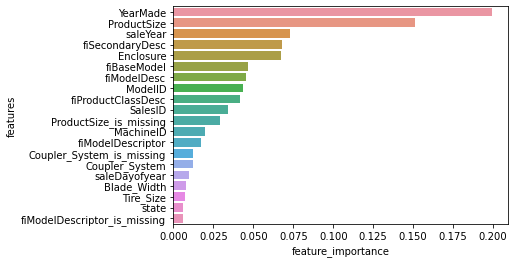

In [71]:
plot_features(X_train.columns, ideal_model.feature_importances_)

We can then check the different values in these most important features to try and see how they may influence the target predictions:

In [72]:
df.ProductSize.isna().sum()

216605

In [73]:
df.ProductSize.value_counts()

Medium            64342
Large / Medium    51297
Small             27057
Mini              25721
Large             21396
Compact            6280
Name: ProductSize, dtype: int64

In [74]:
df.Turbocharged.value_counts()

None or Unspecified    77111
Yes                     3985
Name: Turbocharged, dtype: int64

In [75]:
df.Thumb.value_counts()

None or Unspecified    85074
Manual                  9678
Hydraulic               7580
Name: Thumb, dtype: int64